# Transfer Learning - VGG
In this notebook, i will implement transfer learning from VGG in keras.

imports

In [25]:
import keras
from keras.applications.vgg16 import VGG16
import numpy as np
from keras.datasets import cifar10
from keras.layers import Flatten,Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from PIL import Image
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Parameters and load the dataset

In [3]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4
use_augmentation = False  # use data augmentation technique
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# normalize it
X_train = (X_train/255.) * 2 - 1
X_test = (X_test/255.) * 2 - 1
# from categorical to 1-bit-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Architecture
load a pre-trained version of VGG that was trained over imageNet.
The head of the VGG will be removed in order to modify the model to our classification task.

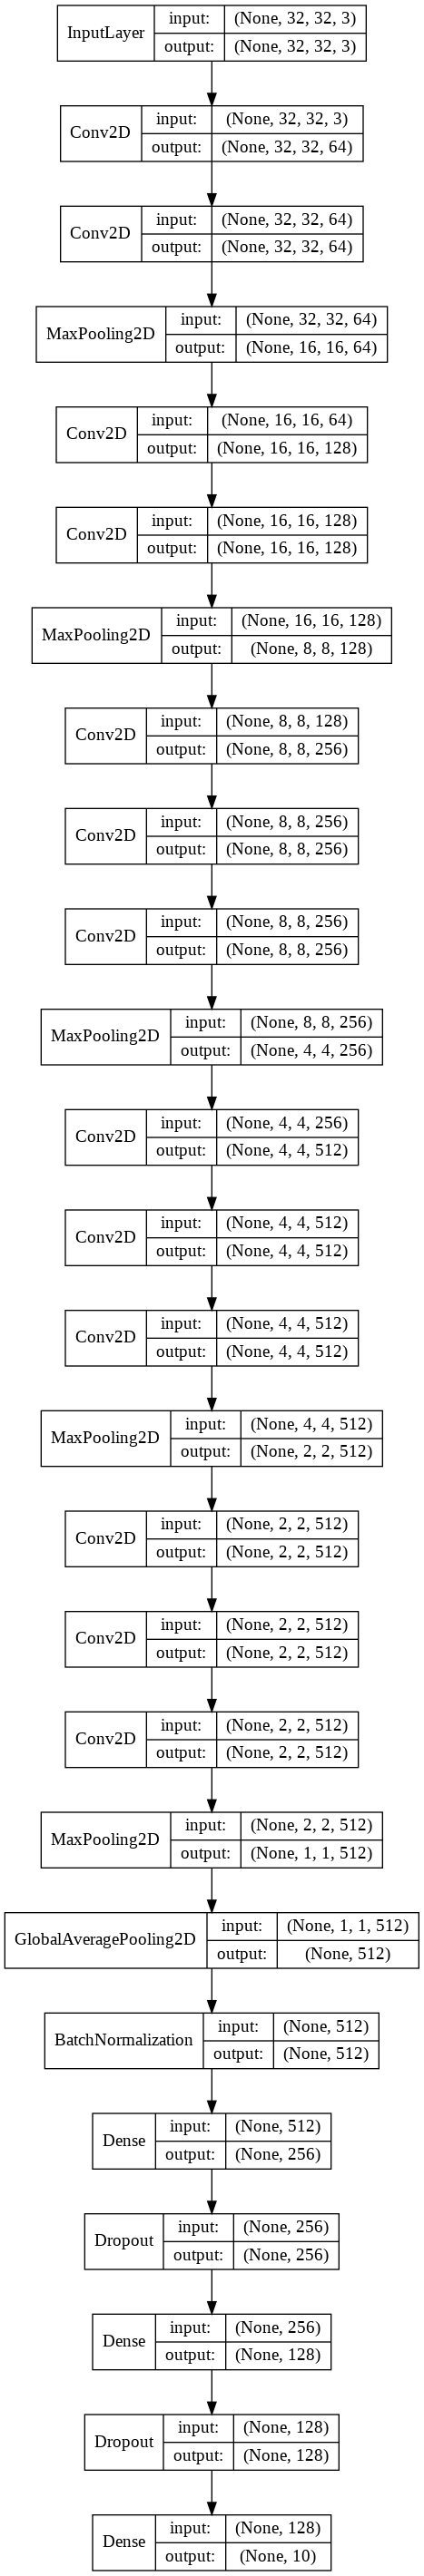

In [19]:
# Load VGG arch with pre-trained weights:

# remove top to remove the classification layer
vgg = VGG16(input_shape=(32,32,3), weights='imagenet', include_top=False)

# freeze the loaded weights so they will not be updated during the training
for layer in vgg.layers:
  layer.trainable = False

# Add a task-based classification parts
x = GlobalAveragePooling2D()(vgg.output)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

# create a model
model = Model(inputs=vgg.input, outputs=output)

# compile it
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=LEARNING_RATE),metrics=['accuracy'])

# visualize the architecture
plot_model(model=model, to_file='model_arch.png',show_shapes=True, show_layer_names=False)

# Train
train the model to minimize the crossentropy loss function.

In [20]:
# prepare data augmentation:
# preprocess_input transforms the input to the needed formation for the VGG
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=preprocess_input)

# create data generators : for train and test sets
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,y_train, batch_size=BATCH_SIZE)

val_datagen.fit(X_test)
val_generator = val_datagen.flow(X_test,y_test,batch_size=BATCH_SIZE)

# calculate steps per_epoch
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_test.shape[0] // BATCH_SIZE

if use_augmentation:
  history = model.fit_generator(train_generator,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator,
                                validation_steps=val_steps_per_epoch,
                                epochs=EPOCHS,
                                verbose=1,
                                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
else:
  history = model.fit(x=X_train, y=y_train,batch_size=BATCH_SIZE,epochs=100,validation_data=[X_test,y_test],
                      callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 17s 336us/step - loss: 0.3049 - accuracy: 0.8978 - val_loss: 0.2342 - val_accuracy: 0.9087
Epoch 2/100
50000/50000 [==============================] - 16s 324us/step - loss: 0.2491 - accuracy: 0.9070 - val_loss: 0.2087 - val_accuracy: 0.9181
Epoch 3/100
50000/50000 [==============================] - 16s 325us/step - loss: 0.2298 - accuracy: 0.9123 - val_loss: 0.1981 - val_accuracy: 0.9219
Epoch 4/100
50000/50000 [==============================] - 16s 324us/step - loss: 0.2195 - accuracy: 0.9157 - val_loss: 0.1912 - val_accuracy: 0.9249
Epoch 5/100
50000/50000 [==============================] - 16s 325us/step - loss: 0.2131 - accuracy: 0.9183 - val_loss: 0.1873 - val_accuracy: 0.9265
Epoch 6/100
50000/50000 [==============================] - 16s 326us/step - loss: 0.2074 - accuracy: 0.9197 - val_loss: 0.1833 - val_accuracy: 0.9283
Epoch 7/100
50000/50000 [=========================

# Analyze training process

evaluate accuracy of the trained model

In [23]:
_, acc = model.evaluate(x=X_test, y=y_test)
print(f'accuracy on test set - {acc:03f}')

10000/10000 [==============================] - 2s 219us/step
accuracy on test set - 0.937540


visualize the performance during the training process

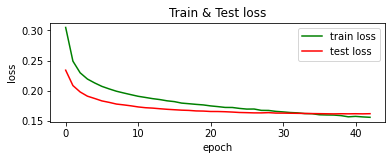

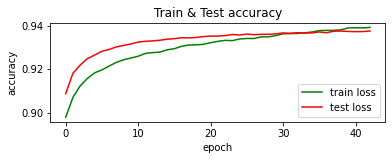

In [26]:
# retrieve losses
train_loss = history.history['loss']
test_loss = history.history['val_loss']
# retrieve accuracies
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# plot loss graph
plt.subplot(2,1,1)
plt.title('Train & Test loss')
plt.plot(train_loss,color='green')
plt.plot(test_loss,color='red')
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
# plot accuracy graph
plt.subplot(2,1,2)
plt.title('Train & Test accuracy')
plt.plot(train_acc,color='green')
plt.plot(test_acc,color='red')
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()